## <font color='darkblue'>Introduction</font>
([article source](https://machinelearningmastery.com/one-class-classification-algorithms/)) **Outliers or anomalies are rare examples that do not fit in with the rest of the data.**

Identifying outliers in data is referred to as outlier or anomaly detection and a subfield of machine learning focused on this problem is referred to as <font color='darkblue'>**one-class classification**</font>. These are unsupervised learning algorithms that attempt to model “normal” examples in order to classify new examples as either normal or abnormal (<font color='brown'>e.g. outliers</font>).

**One-class classification algorithms can be used for binary classification tasks with a severely skewed class distribution**. These techniques can be fit on the input examples from the majority class in the training dataset, then evaluated on a holdout test dataset.

Although not designed for these types of problems, **one-class classification algorithms can be effective for imbalanced classification datasets where there are none or very few examples of the minority class, or datasets where there is no coherent structure to separate the classes that could be learned by a supervised algorithm**.

**In this tutorial, you will discover how to use one-class classification algorithms for datasets with severely skewed class distributions.**

After completing this tutorial, you will know:
* One-class classification is a field of machine learning that provides techniques for outlier and anomaly detection.
* How to adapt one-class classification algorithms for imbalanced classification with a severely skewed class distribution.
* How to fit and evaluate one-class classification algorithms such as SVM, isolation forest, elliptic envelope, and local outlier factor.

### <font color='darkgreen'>Tutorial Overview</font>
This tutorial is divided into five parts; they are:
* <font size='3ptx'>[**One-Class Classification for Imbalanced Data**](#sect1)</font>
* <font size='3ptx'>[**One-Class Support Vector Machines**](#sect2)</font>
* <font size='3ptx'>[**Isolation Forest**](#sect3)</font>
* <font size='3ptx'>[**Minimum Covariance Determinant**](#sect4)</font>
* <font size='3ptx'>[**Local Outlier Factor**](#sect5)</font>

<a id='sect1'></a>
## <font color='darkblue'>One-Class Classification for Imbalanced Data</font>
[**Outliers**](https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/) are both rare and unusual. Rarity suggests that they have a low frequency relative to non-outlier data (<font color='brown'>so-called inliers</font>). Unusual suggests that they do not fit neatly into the data distribution.

**The presence of outliers can cause problems**. For example, a single variable may have an outlier far from the mass of examples, which **can skew summary statistics such as the mean and variance**. 

Fitting a machine learning model may require the identification and removal of outliers as a data preparation technique.

**The process of identifying outliers in a dataset is generally referred to as [anomaly detection](https://en.wikipedia.org/wiki/Anomaly_detection), where the outliers are “anomalies,” and the rest of the data is “normal.”** Outlier detection or anomaly detection is a challenging problem and is comprised of a range of techniques.

In machine learning, one approach to tackling the problem of anomaly detection is [**one-class classification**](https://en.wikipedia.org/wiki/One-class_classification). One-Class Classification, or OCC for short, involves fitting a model on the “normal” data and predicting whether new data is normal or an outlier/anomaly:
> A one-class classifier aims at capturing characteristics of training instances, in order to be able to distinguish between them and potential outliers to appear.
> Page 139, [Learning from Imbalanced Data Sets](https://amzn.to/307Xlva), 2018.

A one-class classifier is fit on a training dataset that only has examples from the normal class. Once prepared, the model is used to classify new examples as either normal or not-normal, i.e. outliers or anomalies.

One-class classification techniques can be used for binary (<font color='brown'>two-class</font>) imbalanced classification problems where the negative case (<font color='brown'>class 0</font>) is taken as “normal” and the positive case (<font color='brown'>class 1</font>) is taken as an outlier or anomaly.
* **Negative Case**: Normal or inlier.
* **Positive Case**: Anomaly or outlier.

Given the nature of the approach, one-class classifications are most suited for those tasks where **the positive cases don’t have a consistent pattern or structure in the feature space, making it hard for other classification algorithms to learn a class boundary.** Instead, treating the positive cases as outliers, it allows one-class classifiers to ignore the task of discrimination and instead focus on deviations from normal or what is expected.
> This solution has proven to be especially useful when the minority class lack any structure, being predominantly composed of small disjuncts or noisy instances. <br/>
> **Page 139, [Learning from Imbalanced Data Sets](https://amzn.to/307Xlva), 2018.**

It may also be appropriate where the number of positive cases in the training set is so few that they are not worth including in the model, such as a few tens of examples or fewer. Or for problems where no examples of positive cases can be collected prior to training a model.

**To be clear, this adaptation of one-class classification algorithms for imbalanced classification is unusual but can be effective on some problems**. **The downside of this approach is that any examples of outliers (<font color='brown'>positive cases</font>) we have during training are not used by the one-class classifier and are discarded**. This suggests that perhaps an inverse modeling of the problem (<font color='brown'>e.g. model the positive case as normal</font>) could be tried in parallel. It also suggests that the one-class classifier could provide an input to an ensemble of algorithms, each of which uses the training dataset in different ways.
> One must remember that the advantages of one-class classifiers come at a price of discarding all of available information about the majority class. Therefore, this solution should be used carefully and may not fit some specific applications. <br/>
> **— Page 140, [Learning from Imbalanced Data Sets](https://amzn.to/307Xlva), 2018.**

The scikit-learn library provides a handful of common one-class classification algorithms intended for use in [**outlier or anomaly detection**](https://scikit-learn.org/stable/modules/outlier_detection.html) and change detection, such as One-Class SVM, Isolation Forest, Elliptic Envelope, and Local Outlier Factor.

In the following sections, we will take a look at each in turn.

Before we do, we will devise a binary classification dataset to demonstrate the algorithms. We will use the [make_classification() scikit-learn function](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) to **create 10,000 examples with 10 examples in the minority class and 9,990 in the majority class, or a 0.1 percent vs. 99.9 percent, or about 1:1000 class distribution**. The example below creates and summarizes this dataset.

Counter({0: 13388, 1: 12})


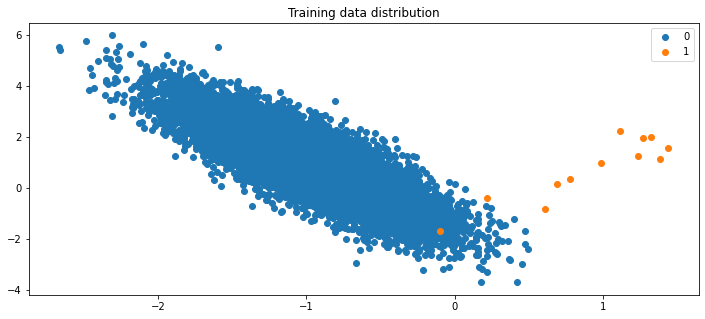

In [52]:
# Generate and plot a synthetic imbalanced classification dataset
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from numpy import where
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,5)

RANDOM_STATE = 42

# define dataset
X, y = make_classification(
    n_samples=20000, 
    n_features=2, 
    n_redundant=0, 
    n_clusters_per_class=1, 
    weights=[0.999], 
    flip_y=0, 
    random_state=RANDOM_STATE
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=RANDOM_STATE)

# summarize class distribution
counter = Counter(y_train)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(y_train == label)[0]
    plt.scatter(X_train[row_ix, 0], X_train[row_ix, 1], label=str(label))
    
plt.title("Training data distribution")    
plt.legend()
plt.show()

Counter({0: 6592, 1: 8})


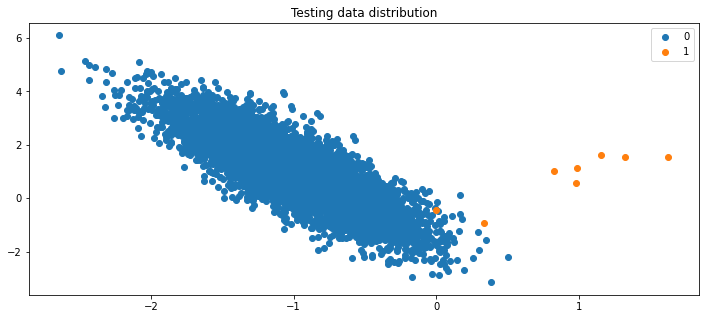

In [64]:
# summarize class distribution
counter = Counter(y_test)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(y_test == label)[0]
    plt.scatter(X_test[row_ix, 0], X_test[row_ix, 1], label=str(label))
    
plt.title("Testing data distribution")    
plt.legend()
plt.show()

This severe class imbalance with so few examples in the positive class and the unstructured nature of the few examples in the positive class might make a good basis for using one-class classification methods.

<a id='sect2'></a>
## <font color='darkblue'>One-Class Support Vector Machines</font>
The [**support vector machine**](https://machinelearningmastery.com/support-vector-machines-for-machine-learning/), or SVM, algorithm developed initially for binary classification can be used for one-class classification. If used for imbalanced classification, it is a good idea to evaluate the standard SVM and weighted SVM on your dataset before testing the one-class version.

**When modeling one class, the algorithm captures the density of the majority class and classifies examples on the extremes of the density function as outliers**. This modification of SVM is referred to as <font color='darkblue'>**One-Class SVM**</font>.
> … an algorithm that computes a binary function that is supposed to capture regions in input space where the probability density lives (its support), that is, a function such that most of the data will live in the region where the function is nonzero. <br/>
> — [Estimating the Support of a High-Dimensional Distribution](https://dl.acm.org/citation.cfm?id=1119749), 2001.

The scikit-learn library provides an implementation of one-class SVM in the [**OneClassSVM class**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM).

The main difference from a standard SVM is that it is fit in an unsupervised manner and does not provide the normal hyperparameters for tuning the margin like `C`. Instead, it **provides a hyperparameter “`nu`” that controls the sensitivity of the support vectors and should be tuned to the approximate ratio of outliers in the data**, e.g. 0.01%.

In [80]:
from sklearn.svm import OneClassSVM

# define outlier detection model
model = OneClassSVM(gamma='scale', nu=0.001)

**The model can be fit on all examples in the training dataset or just those examples in the majority class**. Perhaps try both on your problem. In this case, **we will try fitting on just those examples in the training set that belong to the majority class.**

In [81]:
# fit on majority class
Xtrain_majority = X_train[y_train==0]
model.fit(Xtrain_majority)

OneClassSVM(nu=0.001)

Once fit, the model can be used to identify outliers in new data. When calling the <font color='blue'>predict()</font> function on the model, it will output a **+1 for normal examples, so-called inliers, and a -1 for outliers**.

In [82]:
y_pred = model.predict(X_test)

If we want to **evaluate the performance of the model as a binary classifier, we must change the labels in the test dataset from 0 and 1 for the majority and minority classes respectively, to +1 and -1**.

In [83]:
# mark inliers 0, outliers 1
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

In [84]:
y_pred_df = pd.DataFrame(data=y_pred, columns=['label'])
y_pred_df.label.value_counts()

0    6589
1      11
Name: label, dtype: int64

In [85]:
def draw_confusion_scatter(y_pred, y_test=y_test, X_test=X_test):
    plt.rcParams["figure.figsize"] = (10,5)
    
    # summarize class distribution
    counter = Counter(y_pred)
    print(counter)
    # scatter plot of examples by class label
    label_collect_dict = {'TP':([],[]), 'TN':([],[]), 'FP':([],[]), 'FN':([],[])}
    for x, yp, yt in zip(X_test, y_pred, y_test):
        # plt.scatter(X_test[row_ix, 0], X_test[row_ix, 1], label=str(label))
        if yp == yt and yp == 0:
            label_collect_dict['TN'][0].append(x[0])
            label_collect_dict['TN'][1].append(x[1])        
        elif yp == yt and yp == 1:
            label_collect_dict['TP'][0].append(x[0])
            label_collect_dict['TP'][1].append(x[1])        
        elif yp != yt and yp == 0:
            label_collect_dict['FN'][0].append(x[0])
            label_collect_dict['FN'][1].append(x[1])        
        else:
            label_collect_dict['FP'][0].append(x[0])
            label_collect_dict['FP'][1].append(x[1])        
    
    for label in ['TN', 'TP', 'FP', 'FN']:
        datas = label_collect_dict[label]
        plt.scatter(datas[0], datas[1], label=label)
    
    plt.title("Prediction data distribution")    
    plt.legend()
    plt.show()

Counter({0: 6589, 1: 11})


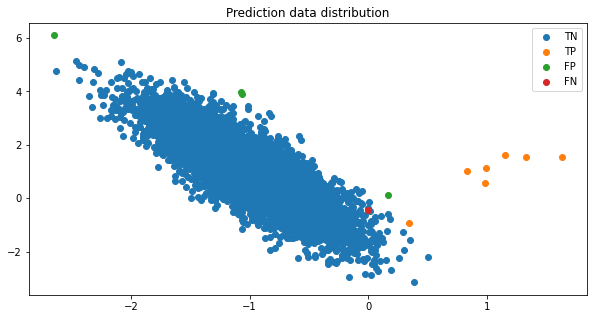

In [86]:
draw_confusion_scatter(y_pred)

We can then compare the predictions from the model to the expected target values and calculate a score. Given that we have crisp class labels, we might use a score like precision, recall, or a combination of both, such as the F-measure (<font color='brown'>F1-score</font>).

In this case, we will use F-measure score, which is the harmonic mean of precision and recall. We can calculate the F-measure using the [f1_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) function and **specify the label of the minority class as -1 via the “pos_label” argument**:

In [87]:
from sklearn.metrics import f1_score, precision_score, recall_score

# calculate score
print(f'F1 Score: {f1_score(y_test, y_pred):.3f}')
print(f'Precision Score: {precision_score(y_test, y_pred):.3f}')
print(f'Recall Score: {recall_score(y_test, y_pred):.3f}')

F1 Score: 0.737
Precision Score: 0.636
Recall Score: 0.875


In this case, an F1 score of 0.737 is achieved.

Tying this together, we can evaluate the one-class SVM algorithm on our synthetic dataset. We will split the dataset in two and use half to train the model in an unsupervised manner and the other half to evaluate it.

<font color='darkred'>**Note**:</font> Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome.

<a id='sect3'></a>
## <font color='darkblue'>Isolation Forest</font>
[**Isolation Forest**](https://en.wikipedia.org/wiki/Isolation_forest), or iForest for short, is a tree-based anomaly detection algorithm.
> … Isolation Forest (iForest) which detects anomalies purely based on the concept of isolation without employing any distance or density measure <br/>
> **— [Isolation-Based Anomaly Detection](https://dl.acm.org/citation.cfm?id=2133363), 2012.**

It is based on modeling the normal data in such a way to isolate anomalies that are both few in number and different in the feature space.
> … our proposed method takes advantage of two anomalies’ quantitative properties: i) they are the minority consisting of fewer instances and ii) they have attribute-values that are very different from those of normal instances. <br/>
> **— [Isolation Forest](https://ieeexplore.ieee.org/abstract/document/4781136), 2008.**

Tree structures are created to isolate anomalies. The result is that **isolated examples have a relatively short depth in the trees, whereas normal data is less isolated and has a greater depth in the trees**.
> … a tree structure can be constructed effectively to isolate every single instance. Because of their susceptibility to isolation, anomalies are isolated closer to the root of the tree; whereas normal points are isolated at the deeper end of the tree. <br/>
> **— [Isolation Forest](https://ieeexplore.ieee.org/abstract/document/4781136), 2008.**

The scikit-learn library provides an implementation of Isolation Forest in the [**IsolationForest class**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html).

**Perhaps the most important hyperparameters of the model are the “<font color='violet'>n_estimators</font>” argument that sets the number of trees to create and the “contamination” argument**, which is used to help define the number of outliers in the dataset.

We know the **contamination is about 0.01 percent positive cases to negative cases**, so we can set the “contamination” argument to be 0.01.

In [168]:
from sklearn.ensemble import IsolationForest

# define outlier detection model
model = IsolationForest(
    #contamination='auto',
    contamination=0.03,    
    random_state=RANDOM_STATE,
    n_estimators=150,
)

Then it is time to train the model:

In [169]:
%time model.fit(X_train)

Wall time: 748 ms


IsolationForest(contamination=0.03, n_estimators=150, random_state=42)

Like one-class SVM, the model will **predict an inlier with a label of +1 and an outlier with a label of -1**, therefore, the labels of the test set must be changed before evaluating the predictions.

In [170]:
import pandas as pd

y_pred = model.predict(X_test)
y_pred_df = pd.DataFrame(data=y_pred, columns=['label'])
y_pred_df.label.value_counts()

 1    6422
-1     178
Name: label, dtype: int64

In [171]:
# mark inliers 0, outliers 1
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

In [172]:
y_pred_df = pd.DataFrame(data=y_pred, columns=['label'])
y_pred_df.label.value_counts()

0    6422
1     178
Name: label, dtype: int64

In [173]:
# calculate score
print(f'F1 Score: {f1_score(y_test, y_pred):.3f}')
print(f'Precision Score: {precision_score(y_test, y_pred):.3f}')
print(f'Recall Score: {recall_score(y_test, y_pred):.3f}')

F1 Score: 0.075
Precision Score: 0.039
Recall Score: 0.875


Counter({0: 6422, 1: 178})


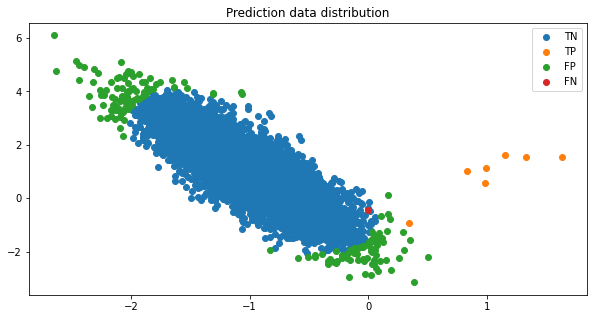

In [174]:
draw_confusion_scatter(y_pred)

**Running the example fits the isolation forest model on the training dataset in an unsupervised manner**, then classifies examples in the test set as inliers and outliers and scores the result.

<a id='sect4'></a>
## <font color='darkblue'>Minimum Covariance Determinant</font>
If the input variables have a [**Gaussian distribution**](https://machinelearningmastery.com/continuous-probability-distributions-for-machine-learning/), then simple statistical methods can be used to detect outliers.

For example, if the dataset has two input variables and both are Gaussian, then the feature space forms a multi-dimensional Gaussian and knowledge of this distribution can be used to identify values far from the distribution.

This approach can be generalized by defining a hypersphere (<font color='brown'>ellipsoid</font>) that covers the normal data, and data that falls outside this shape is considered an outlier. An efficient implementation of this technique for multivariate data is known as the <font color='darkblue'>**Minimum Covariance Determinant**</font>, or MCD for short.

It is unusual to have such well-behaved data, but if this is the case for your dataset, or you can use power transforms to make the variables Gaussian, then this approach might be appropriate.
> The Minimum Covariance Determinant (MCD) method is a highly robust estimator of multivariate location and scatter, for which a fast algorithm is available. It also serves as a convenient and efficient tool for outlier detection. <br/>
> **— [Minimum Covariance Determinant and Extensions](https://arxiv.org/abs/1709.07045), 2017.**

The scikit-learn library provides access to this method via the [**EllipticEnvelope class**](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope).

It provides **the “contamination” argument that defines the expected ratio of outliers to be observed in practice**. We know that this is 0.01 percent in our synthetic dataset, so we can set it accordingly.

In [175]:
from sklearn.covariance import EllipticEnvelope

# define outlier detection model
model = EllipticEnvelope(contamination=0.01)

**The model can be fit on the input data from the majority class only in order to estimate the distribution of “normal” data in an unsupervised manner**. For example:

In [177]:
# fit on majority class
Xtrain_majority = X_train[y_train==0]
%time model.fit(Xtrain_majority)

Wall time: 3.01 s


EllipticEnvelope(contamination=0.01)

The model will then be used to classify new examples as either **ormal (+1) or outliers (-1)**:

In [178]:
import pandas as pd

y_pred = model.predict(X_test)
y_pred_df = pd.DataFrame(data=y_pred, columns=['label'])
y_pred_df.label.value_counts()

 1    6538
-1      62
Name: label, dtype: int64

In [179]:
# mark inliers 0, outliers 1
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

In [180]:
# calculate score
print(f'F1 Score: {f1_score(y_test, y_pred):.3f}')
print(f'Precision Score: {precision_score(y_test, y_pred):.3f}')
print(f'Recall Score: {recall_score(y_test, y_pred):.3f}')

F1 Score: 0.200
Precision Score: 0.113
Recall Score: 0.875


Counter({0: 6538, 1: 62})


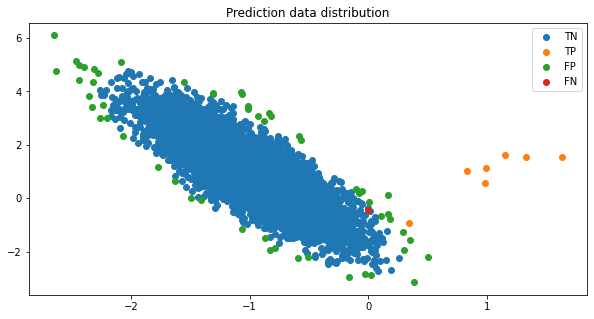

In [181]:
draw_confusion_scatter(y_pred)

<a id='sect5'></a>
## <font color='darkblue'>Local Outlier Factor</font>
A simple approach to identifying outliers is to **locate those examples that are far from the other examples in the feature space.**

This can work well for feature spaces with low dimensionality (<font color='brown'>few features</font>), <font color='darkred'>**although it can become less reliable as the number of features is increased, referred to as the curse of dimensionality.**</font>

The local outlier factor, or LOF for short, is a technique that attempts to harness the idea of nearest neighbors for outlier detection. **Each example is assigned a scoring of how isolated or how likely it is to be outliers based on the size of its local neighborhood. Those examples with the largest score are more likely to be outliers.**
> We introduce a local outlier (LOF) for each object in the dataset, indicating its degree of outlier-ness. <br/>
> **— [LOF: Identifying Density-based Local Outliers](https://dl.acm.org/citation.cfm?id=335388), 2000.**

The scikit-learn library provides an implementation of this approach in the [**LocalOutlierFactor class**](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor). The model can be defined and requires that the expected percentage of outliers in the dataset be indicated, such as 0.01 percent in the case of our synthetic dataset.

In [182]:
from sklearn.neighbors import LocalOutlierFactor

# define outlier detection model
model = LocalOutlierFactor(
    contamination=0.01
)

The model is not fit. Instead, a “normal” dataset is used as the basis for identifying outliers in new data via a call to <font color='blue'>fit_predict()</font>. **To use this model to identify outliers in our test dataset, we must first prepare the training dataset to only have input examples from the majority class.**

In [184]:
# fit on majority class
Xtrain_majority = X_train[y_train==0]

Next, we can concatenate these examples with the input examples from the test dataset.

In [185]:
from numpy import vstack

composite = vstack((Xtrain_majority, X_test))

We can then make a prediction by calling <font color='blue'>fit_predict()</font> and retrieve only those labels for the examples in the test set.

In [186]:
# make prediction on composite dataset
y_pred = model.fit_predict(composite)
# get just the predictions on the test set
y_pred = y_pred[len(Xtrain_majority):]

**The predicted labels will be +1 for normal and -1 for outliers**, like the other outlier detection algorithms in scikit-learn.

In [187]:
# mark inliers 0, outliers 1
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

In [188]:
# calculate score
print(f'F1 Score: {f1_score(y_test, y_pred):.3f}')
print(f'Precision Score: {precision_score(y_test, y_pred):.3f}')
print(f'Recall Score: {recall_score(y_test, y_pred):.3f}')

F1 Score: 0.200
Precision Score: 0.113
Recall Score: 0.875


Counter({0: 6538, 1: 62})


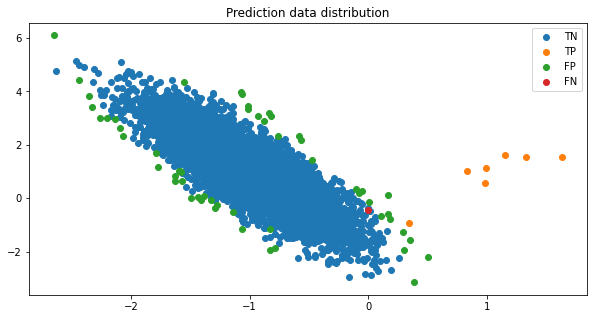

In [189]:
draw_confusion_scatter(y_pred)

For more, you can refer to scikit-learn article [**Outlier detection with Local Outlier Factor (LOF)**](https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html).

<a id='supplement'></a>
## <font color='darkblue'>Further Reading</font>
* [Python机器学习笔记：异常点检测算法——Isolation Forest](https://www.cnblogs.com/wj-1314/p/10461816.html)

### <font color='darkgreen'>Papers</font>
* [Estimating the Support of a High-Dimensional Distribution, 2001.](https://dl.acm.org/citation.cfm?id=1119749)
* [Isolation Forest, 2008.](https://ieeexplore.ieee.org/abstract/document/4781136)
* [Isolation-Based Anomaly Detection, 2012.](https://dl.acm.org/citation.cfm?id=2133363)
* [A Fast Algorithm for the Minimum Covariance Determinant Estimator, 2012.](https://amstat.tandfonline.com/doi/abs/10.1080/00401706.1999.10485670)
* [Minimum Covariance Determinant and Extensions, 2017.](https://arxiv.org/abs/1709.07045)
* [LOF: Identifying Density-based Local Outliers, 2000.](https://dl.acm.org/citation.cfm?id=335388)


### <font color='darkgreen'>Books</font>
* [Learning from Imbalanced Data Sets, 2018.](https://amzn.to/307Xlva)
* [Imbalanced Learning: Foundations, Algorithms, and Applications, 2013.](https://amzn.to/32K9K6d)
